<a href="https://colab.research.google.com/github/bhanulk/supplier_reliability_prediction/blob/main/Supplier_Reliability_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**DATA PREPOCESSING **

In [3]:
# ----------------------------
# Supplier Reliability Preprocessing
# ----------------------------

import pandas as pd
import numpy as np

# 1. Load Dataset
file_path = "/content/drive/MyDrive/Supplier Reliability/synthetic_supplier_dataset 2.csv"  # <-- change if your file name is different
df = pd.read_csv(file_path)

# 2. Convert Date Columns
date_cols = ["Order_Date", "Requested_Delivery_Date", "Delivery_Date"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce", dayfirst=True)

# 3. Feature Engineering
# Profit margin per order
df["Profit_Margin"] = (df["Negotiated_Price"] - df["Unit_Price"]) / df["Unit_Price"]

# 4. Supplier-Level Aggregation
supplier_agg = df.groupby("Supplier_ID").agg(
    avg_delivery_delay=("Delivery_Delay_days", "mean"),
    on_time_rate=("Delivery_Delay_days", lambda x: np.mean(x <= 0)),
    avg_defective_rate=("Defective_Rate", "mean"),
    avg_defective_units=("Defective_Units", "mean"),
    avg_response_time=("Recorded_Communication_ResponseTime_hrs", "mean"),
    avg_profit_margin=("Profit_Margin", "mean"),
    total_orders=("PO_ID", "count")
).reset_index()

# 5. Normalization Function
def normalize(series, inverse=False):
    """Normalize a series to 0–1.
       If inverse=True, lower values are better (flip scale)."""
    if series.max() == series.min():  # avoid divide-by-zero
        return np.ones(len(series)) * 0.5
    if inverse:
        return 1 - ((series - series.min()) / (series.max() - series.min()))
    else:
        return (series - series.min()) / (series.max() - series.min())

# 6. Calculate Factor Scores (0–1 scaled)
supplier_agg["delay_score"] = normalize(supplier_agg["avg_delivery_delay"], inverse=True)
supplier_agg["quality_score"] = normalize(supplier_agg["avg_defective_rate"], inverse=True)
supplier_agg["responsiveness_score"] = normalize(supplier_agg["avg_response_time"], inverse=True)
supplier_agg["profit_score"] = normalize(supplier_agg["avg_profit_margin"], inverse=False)

# 7. Combine into Proxy Reliability Score
supplier_agg["reliability_score"] = (
    0.3 * supplier_agg["delay_score"] +
    0.3 * supplier_agg["quality_score"] +
    0.2 * supplier_agg["responsiveness_score"] +
    0.2 * supplier_agg["profit_score"]
)

# 8. Save Preprocessed Supplier Table
supplier_agg.to_csv("/content/drive/MyDrive/Supplier Reliability/supplier_reliability_features-2.csv", index=False)

print("✅ Preprocessing done! File saved as supplier_reliability_features.csv")
supplier_agg.head()


✅ Preprocessing done! File saved as supplier_reliability_features.csv


/tmp/ipython-input-255718231.py:15: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors="coerce", dayfirst=True)
/tmp/ipython-input-255718231.py:15: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors="coerce", dayfirst=True)


,Supplier_ID,avg_delivery_delay,on_time_rate,avg_defective_rate,avg_defective_units,avg_response_time,avg_profit_margin,total_orders,delay_score,quality_score,responsiveness_score,profit_score,reliability_score
0,SUPP_0001,0.670330,0.692308,0.017556,26.439560,24.039560,-0.024817,91,0.693093,0.584896,0.492327,0.357912,0.553444
1,SUPP_0002,0.845361,0.711340,0.019014,32.670103,23.521649,-0.022839,97,0.533689,0.164457,0.574371,0.442845,0.412887
2,SUPP_0003,0.895652,0.704348,0.018406,33.782609,23.868696,-0.009866,115,0.487888,0.339656,0.519394,1.000000,0.552142
3,SUPP_0004,0.976190,0.750000,0.016901,41.892857,25.361905,-0.022414,84,0.414541,0.773679,0.282850,0.461077,0.505251
4,SUPP_0005,0.653465,0.742574,0.017230,44.198020,24.891089,-0.023090,101,0.708451,0.678726,0.357433,0.432065,0.574053


**MODEL TRAINING - XGBoost**

✅ Using RAW supplier features
💾 Model saved as 'supplier_reliability_model.pkl'
    Actual_Score  Predicted_Score Actual_Category Predicted_Category
0       0.507213         0.518119          Medium             Medium
1       0.526085         0.471773          Medium             Medium
2       0.530287         0.551942          Medium             Medium
3       0.369606         0.395373           Risky              Risky
4       0.315198         0.335148           Risky              Risky
5       0.532388         0.581587          Medium             Medium
6       0.529481         0.528601          Medium             Medium
7       0.479562         0.489213          Medium             Medium
8       0.377389         0.388911           Risky              Risky
9       0.464579         0.452868          Medium             Medium
10      0.375648         0.383391           Risky              Risky
11      0.320224         0.354476           Risky              Risky
12      0.649011       

<Figure size 800x600 with 0 Axes>

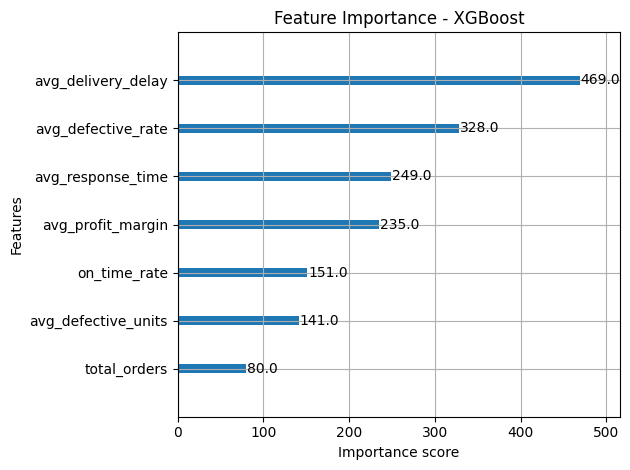

📊 Feature importance plot saved as 'feature_importance.png'

🔮 New Supplier Prediction:
ML Model → Score: 0.345 → Category: Risky
Dynamic (User-Weighted) → Score: 0.695 → Category: Medium


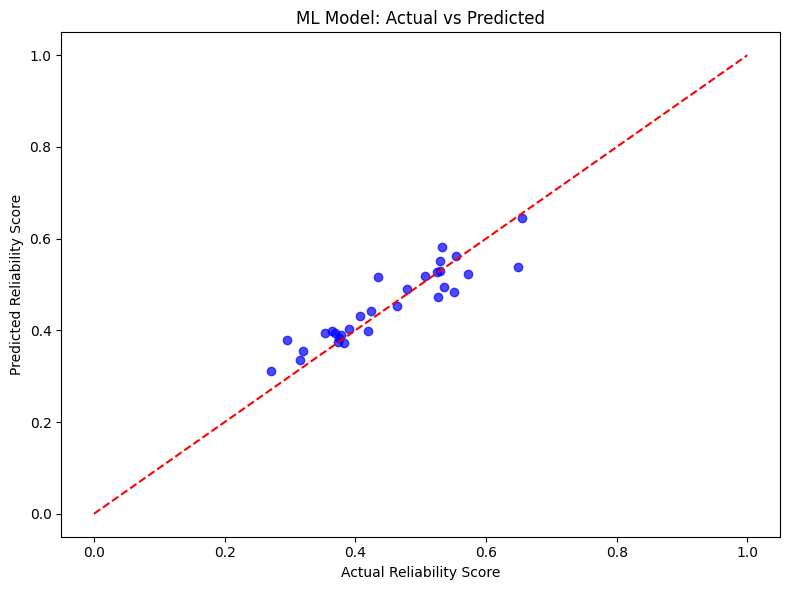

📊 Actual vs Predicted plot saved as 'actual_vs_predicted.png'


In [8]:
# ----------------------------
# Supplier Reliability: Unified Pipeline + Visualization + Model Save
# ----------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import joblib  # for saving the model
from xgboost import plot_importance
# 1. Load dataset
df = pd.read_csv("/content/drive/MyDrive/Supplier Reliability/supplier_reliability_features-2.csv")

# ----------------------------
# 2. Switch Between Raw & Score Features
# ----------------------------
USE_SCORE_FEATURES = False  # 🔄 Toggle here

if USE_SCORE_FEATURES:
    feature_cols = ["delay_score", "quality_score", "responsiveness_score", "profit_score"]
    print("✅ Using SCORE-based features")
else:
    feature_cols = [
        "avg_delivery_delay",
        "on_time_rate",
        "avg_defective_rate",
        "avg_defective_units",
        "avg_response_time",
        "avg_profit_margin",
        "total_orders"
    ]
    print("✅ Using RAW supplier features")

X = df[feature_cols]
y = df["reliability_score"]

# ----------------------------
# 3. Train-Test Split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------
# 4. Train XGBoost
# ----------------------------
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Save the trained model
joblib.dump(xgb_model, "/content/drive/MyDrive/Supplier Reliability/supplier_reliability_model-2.pkl")
print("💾 Model saved as 'supplier_reliability_model.pkl'")

# ----------------------------
# 5. Predictions (ML Reliability)
# ----------------------------
y_preds = xgb_model.predict(X_test)

# ----------------------------
# 6. Categorization Function
# ----------------------------
def categorize_score(score):
    if score >= 0.7:
        return "Reliable"
    elif score >= 0.4:
        return "Medium"
    else:
        return "Risky"

# True vs Predicted with categories
results_df = pd.DataFrame({
    "Actual_Score": y_test.values,
    "Predicted_Score": y_preds,
    "Actual_Category": [categorize_score(s) for s in y_test],
    "Predicted_Category": [categorize_score(s) for s in y_preds]
})

print(results_df)


# Regression Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
r2 = r2_score(y_test, y_preds)
print(f"\n📊 Regression → RMSE: {rmse:.4f}, R²: {r2:.4f}")



true_categories = [categorize_score(s) for s in y_test]
pred_categories = [categorize_score(s) for s in y_preds]

print("\n📊 Classification Report (ML Score):")
print(classification_report(true_categories, pred_categories))

# ----------------------------
# 7. Feature Importance Plot
# ----------------------------
plt.figure(figsize=(8,6))
plot_importance(xgb_model, max_num_features=10)
plt.title("Feature Importance - XGBoost")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()
print("📊 Feature importance plot saved as 'feature_importance.png'")

# ----------------------------
# 8. Dynamic Weighted Score Function
# ----------------------------
def compute_dynamic_score(row, weights):
    return (
        weights["delay"] * row["delay_score"] +
        weights["quality"] * row["quality_score"] +
        weights["responsiveness"] * row["responsiveness_score"] +
        weights["profit"] * row["profit_score"]
    )

# Example user-defined weights
user_weights = {
    "delay": 0.4,
    "quality": 0.3,
    "responsiveness": 0.2,
    "profit": 0.1
}

# ----------------------------
# 9. Example: New Supplier
# ----------------------------
if USE_SCORE_FEATURES:
    new_supplier = pd.DataFrame([{
        "delay_score": 0.75,
        "quality_score": 0.85,
        "responsiveness_score": 0.60,
        "profit_score": 0.55
    }])
else:
    new_supplier = pd.DataFrame([{
        "avg_delivery_delay": 2.0,
        "on_time_rate": 0.85,
        "avg_defective_rate": 0.03,
        "avg_defective_units": 4,
        "avg_response_time": 12.5,
        "avg_profit_margin": 0.18,
        "total_orders": 20,
        # Extra factor scores for dynamic scoring
        "delay_score": 0.7,
        "quality_score": 0.8,
        "responsiveness_score": 0.6,
        "profit_score": 0.55
    }])

# ML-based score
ml_score = xgb_model.predict(new_supplier[feature_cols])[0]
ml_category = categorize_score(ml_score)

# User-weighted dynamic score
dyn_score = compute_dynamic_score(new_supplier.iloc[0], user_weights)
dyn_category = categorize_score(dyn_score)

print("\n🔮 New Supplier Prediction:")
print(f"ML Model → Score: {ml_score:.3f} → Category: {ml_category}")
print(f"Dynamic (User-Weighted) → Score: {dyn_score:.3f} → Category: {dyn_category}")

# ----------------------------
# 10. Visual Representation of Test Set Predictions
# ----------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_preds, color='blue', alpha=0.7)
plt.plot([0,1], [0,1], 'r--')  # perfect prediction line
plt.xlabel("Actual Reliability Score")
plt.ylabel("Predicted Reliability Score")
plt.title("ML Model: Actual vs Predicted")
plt.tight_layout()
plt.savefig("actual_vs_predicted.png")
plt.show()
print("📊 Actual vs Predicted plot saved as 'actual_vs_predicted.png'")
